In [1]:
''' Import the fundamental modules '''
import sys
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from IPython import display
from torch import nn
from torch.utils import data
from torchvision import transforms

## *Accumulator Class*
The Accumulator is a class whose data consist of *n* number of cells (specified when initialising the object) containing the sums of numbers, the inputs in `Accumulator.add()`.

`Accumulator.reset()` will reset the object's data cells to 0.0, maintaining the same dimension
`Accumulator.__getitem__()` is a private method to find the data at a specified index

## *Animator Class*
The Animator class is used to collect and plot data, regarding the *training* and *validation accuracy* as well as *loss*, using *matplotlib* during the execution of the training loop. The function `Animator.add()` is used to add and plot data to the object

## *set_axes function*
The `set_axes()` is a simple function to setup the axes for plots via matplotlib

## *init_weights function*
The `init_weights()` function initialises the weights of the model to random values, and bias to zero. It is useful when multiple layers of the same type have to be initialized in the same way.

## *accuracy function*
The function `accuracy(y, y_hat)` is to compare the predictions with the tests, it returns the number of correct predictions.

* y_hat is a matrix, its 2nd dimension stores a list of prediction scores for each class
* the index of the highest score (in the 2nd dimension of y_hat) indicates the predicted class
* the predictions *y_hat* are compared with the test *y*
* taking the sum yields the total number of correct predictions

## *eval_accuracy function*
The function `eval_accuracy()` computes the overall accuracy of the model by comparing the amount of correct predicitons to the total number of predictions.
* It sets the model to evaluation mode by using the `net.eval()` method
* An accumulator object is created to contain 2 variables: the no. of correct predictions, and the no. of total predictions
* The accuracy is calculated by dividing the sum of correct predicitons by the sums of total predictions

In [2]:
"""Some class and function definitions"""

''' Define accumulator class for accumulating sums over `n` variables '''
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


""" Plotting data in animation """
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        
        # Incrementally plot multiple lines
        if legend is None:
            legend = []

        # Use the svg format to display a plot in Jupyter
        #display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
            
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    
    # Add multiple data points into the figure
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


""" Set the axes for matplotlib """
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


''' Weight instantiation and initialisation '''
def init_weights(m):
    # check type to init different layers in different ways
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)
        torch.nn.init.zeros_(m.bias)


''' Compute the number of correct predictions '''
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.

    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)        # Predicted class is the index of max score    
        
    cmp = (y_hat.type(y.dtype) == y)        # because`==` is sensitive to data types
    return float(torch.sum(cmp))



''' Compute the accuracy for a model on a dataset '''
def eval_accuracy(net, data_iter):
    
    # Set the model to evaluation mode
    if isinstance(net, torch.nn.Module):
        net.eval()
        
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
        
    return metric[0] / metric[1]



argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)

## Reading the Dataset
PyTorch has an abstract *Dataset* class.

1. A Dataset can be anything that has a **`__len__`** function (called by Python’s standard `len` function) and a **`__getitem__`** function as a way of indexing into it.

    PyTorch’s *`torch.utils.data.TensorDataset(features, labels)`* is a *Dataset wrapper for tensors*. By defining a length and way of indexing, this also gives a way to iterate, index, and slice along the first dimension of a tensor.
    In general any created Dataset class has to be implemented, extending `torch.utils.data.Dataset`

2. In order to itareate through the dataset, `torch.utils.data.DataLoader(dataset, batch_size)` is used. In addition to iterate through the dataset, this also provides built-in functionality for:
    * Batching the data
    * Shuffling the data
    * Load the data in parallel using multiprocessing workers

## FashionMNIST Dataset
The *FashionMNIST dataset* a dataset of Zalando's article images consisting of a training set of 60,000 samples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image, associated with a label from 10 classes.

The train and test dataset are now loaded using the `datasets.FashionMNIST()` function in the `torchvision` module with a batch size of 256 samples.

***The argument `train=True/False` decides which set to load between the train or test sets.***

In [3]:
# Download the Fashion-MNIST dataset, load it into memory, and read training and test batches
resize = None
batch_size = 256
trans = [transforms.ToTensor()]

if resize:
    trans.insert(0, transforms.Resize(resize))

trans = transforms.Compose(trans)
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4) # num_workers:processes to read the data ( use 4)

## The Model
The neural network model used here has one backbone block with two MLPs. Each MLP is made of two linear functions and one activation function, and the layers are implemented in a sequence using ‘nn.Sequential’.

## Stem
The Stem is defined as a class method and is used to split the input image tensor into N number of square patches, vectorise the patches and finally output a feature matrix 𝑋∈𝑅 , with d = features.

## Classifier
The classifier is also declared as a class method to extract the mean feature vector x∈𝑅 from the feature matrix. The mean features will be directly used for the classification and training process.

In [4]:
class Net(torch.nn.Module):

  def __init__(self, num_inputs, num_hidden, num_outputs):
      super(Net, self).__init__()

      self.num_hidden = num_hidden
      self.num_inputs = num_inputs
      self.num_outputs = num_outputs

      self.backbone_mlp1 = nn.Sequential(
                          nn.Linear(num_hidden, num_hidden), 
                          nn.ReLU(),
                          nn.Linear(num_hidden, num_hidden))
      
      self.backbone_mlp2 = nn.Sequential(
                          nn.Linear(num_inputs, num_inputs), 
                          nn.ReLU(), 
                          nn.Linear(num_inputs, num_inputs))

  def forward(self, x):

      x = self.Stem(x, 7)
      
      x = torch.transpose(x, 1, 2)    # transpose before first backbone mlp
      x = self.backbone_mlp1(x)

      x = torch.transpose(x, 1, 2)  # transpose before second backbone mlp
      x = self.backbone_mlp2(x)
      
      out = self.Classifier(x)

      return out
    
  def Stem(self, x, PATCH_SIZE):
      '''
      A function to split the input image into square patches
      and then rearrange the pixels in each patch.
      The input image of size (h, w) is rearranged into (num_patches, patch_size^2).
      
      - PATCH_SIZE is the lenght of the square patch in pixels
      (i.e. 7x7 patch: PATCH_SIZE=7).

      - num_patches is the number of patches in the image,
      it is calculated by dividing the image size by the patch size
      '''
      PATCH_SIZE
      num_patches = (28//PATCH_SIZE)**2
      unfold = nn.Unfold(kernel_size=(7,7), stride=(7,7))

      x_divided = x.unfold(2, PATCH_SIZE, PATCH_SIZE)\
                  .unfold(3, PATCH_SIZE, PATCH_SIZE)
        
      x_divided = x_divided.reshape( -1, num_patches,\
                                    PATCH_SIZE, PATCH_SIZE)
              
      return x_divided.reshape(-1, num_patches, PATCH_SIZE**2)

  def Classifier(self, x):
      '''
      A function to extract the mean feature vector
      from the feature matrix and that will be directly used for the
      classification and training process
      '''
      x = x.mean(1, False)
      #print('after mean: ', x.size())      

      return x

## Training
In order to fix the weights of the neural network to make correct predictions, the model has to be **trained** many times recurrently. The training loop has a defined number of iterations (**epochs**) which affects the overall accuracy and performance of the ultimate model.

This training loop is fixed for softmax regression, implemented to make it reusable.

* `train_epoch()` : function for training on each epoch of the loop, it computes and stores the values of accuracy and loss
* `train()` : function to create a training loop, collect data over the iterations and plot results

In [5]:
def train_epoch(net, train_iter, loss, updater):
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]


#Train a model
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = eval_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        
    train_loss, train_acc = train_metrics
    print('train final accuracy: ', train_acc)
    print('test final loss: ', train_loss)
    print('test final accuracy: ', test_acc)


In [6]:
num_inputs, num_hidden, num_outputs = 49, 16, 10
net = Net(num_inputs, num_hidden, num_outputs)
net.apply(init_weights)

Net(
  (backbone_mlp1): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  )
  (backbone_mlp2): Sequential(
    (0): Linear(in_features=49, out_features=49, bias=True)
    (1): ReLU()
    (2): Linear(in_features=49, out_features=49, bias=True)
  )
)

## Loss Function

Use PyTorch's implementation of Softmax-Cross Entropy loss to avoid numerical instabilities. The input to loss function are the logits $\mathbf{o}$ (and not softmax outputs).

`loss = nn.CrossEntropyLoss()`

## Optimization Algorithm
*Minibatch SGD* is a standard tool for optimizing neural networks (a number of variations of this algorithm can be found in the `optim` module).

To initialize an `SGD` optimizer:
* The parameters to optimize (obtainable from the net via `net.parameters()`), 
* A dictionary of hyperparameters required:
  * just require to set the learning rate `lr` and weight decay `wd`
 
`optimizer = torch.optim.SGD(net.parameters(), lr=..., weight_decay=...)`


In [7]:
# Create your loss here. Use Cross Entropy loss:
loss = nn.CrossEntropyLoss()

lr = 0.6
wd = 0.0002

# Creare your optimizer here. Use SGD with weight decay wd and learning rate lr.
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

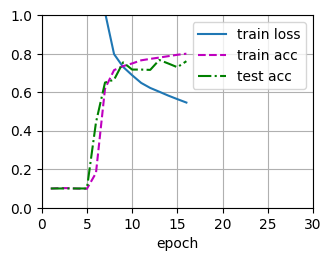

In [ ]:
num_epochs = 30
train(net, train_iter, test_iter, loss, num_epochs, optimizer)

Several attempt where made adjusting the learning rate (between 0.6 and 0.2) and 
weight decay (between 0.0002 and 0.0007) 

BEST SETTINGS:
num_inputs, num_hidden, num_outputs = 49, 16, 10 
* learning rate = 0.6
* weight decay = 0.0002
* epochs = 30
* loss = nn.CrossEntropyLoss()
* optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)